In [1]:
import os, glob, warnings
import numpy as np
import pandas as pd
import cv2
import librosa
import librosa.display
import moviepy.editor as mp
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display

warnings.filterwarnings("ignore")

In [20]:
# Configuration
DATA_DIR = "./data"
GT_FILES = glob.glob(os.path.join(DATA_DIR, "ground_truth", "*.xlsx"))
VIDEO_FILES = glob.glob(os.path.join(DATA_DIR, "episodes", "*.avi"))
AUDIO_DIR = os.path.join(DATA_DIR, "audio")
CACHE_FILE = os.path.join(DATA_DIR, "audio_features.npz")

SEED = 12332287
CLASSES = ["MissPiggy", "OtherPigs", "SwedishChef", "Rowlf"]

# Sample audio exploration parameters
SAMPLE_VIDEO_FILE = VIDEO_FILES[0] if VIDEO_FILES else None
SAMPLE_FRAME_NUMBER = 10000
SAMPLE_AUDIO_SEC = 100  # Start time in seconds for exploration
SAMPLE_AUDIO_WINDOW_SEC = 2  # Duration in seconds
AUDIO_WINDOW_FRAMES = 50  # Number of frames for audio window

np.random.seed(SEED)

In [3]:
# Ground Truth Configuration
GT_REQUIRED = [
    "Video", "Frame_number", "Timestamp",
    "Kermit", "Pigs", "Miss Piggy", "Cook",
    "StatlerWaldorf", "Rowlf the Dog", "Fozzie Bear"
]

GT_TO_INTERNAL = {
    "Miss Piggy": "MissPiggy",
    "Pigs": "OtherPigs",
    "Cook": "SwedishChef",
    "Rowlf the Dog": "Rowlf",
}

## Load Ground Truth

In [4]:
def read_ground_truth(gt_dir):
    """reads all ground truth xlsx files and returns df indexed by (Video, Frame_number)"""
    files = sorted(glob.glob(os.path.join(gt_dir, "*.xlsx")))
    if not files:
        raise FileNotFoundError("no ground truth xlsx found in gt_dir")

    dfs = []
    for path in files:
        df = pd.read_excel(path)

        # verify headers
        missing = [c for c in GT_REQUIRED if c not in df.columns]
        if missing:
            raise ValueError(f"{os.path.basename(path)} missing columns: {missing}")

        # enforce numeric dtypes
        df["Video"] = pd.to_numeric(df["Video"], errors="coerce").astype("Int64")
        df["Frame_number"] = pd.to_numeric(df["Frame_number"], errors="coerce").astype("Int64")

        # map exact GT columns to internal class names
        for gt_col, internal in GT_TO_INTERNAL.items():
            df[internal] = pd.to_numeric(df[gt_col], errors="coerce").fillna(0).astype(int)

        dfs.append(df[["Video", "Frame_number"] + list(GT_TO_INTERNAL.values())])

    gt = pd.concat(dfs, ignore_index=True)
    gt = gt.dropna(subset=["Video", "Frame_number"])
    gt["Video"] = gt["Video"].astype(int)
    gt["Frame_number"] = gt["Frame_number"].astype(int)

    gt = gt.set_index(["Video", "Frame_number"]).sort_index()

    for c in CLASSES:
        if c not in gt.columns:
            gt[c] = 0
        gt[c] = gt[c].astype(int)

    return gt

gt_df = read_ground_truth("./data/ground_truth")

## Audio Extraction Utilities

In [5]:
def video_to_audio(video_path, audio_dir="./data/audio"):
    """Extract audio from video and save as wav file"""
    os.makedirs(audio_dir, exist_ok=True)
    fname = os.path.basename(video_path).replace(".avi", ".wav")
    audio_out = os.path.join(audio_dir, fname)
    
    if os.path.exists(audio_out):
        print(f"Audio already exists: {audio_out}")
        return audio_out

    # load video file and extract audio
    video = mp.VideoFileClip(video_path)
    video.audio.write_audiofile(audio_out, codec="pcm_s16le")
    video.close()
    return audio_out

In [6]:
# Extract audio from all videos (if not already done)
os.makedirs(AUDIO_DIR, exist_ok=True)
for v in VIDEO_FILES:
    video_to_audio(v, AUDIO_DIR)

Audio already exists: ./data/audio/211.wav
Audio already exists: ./data/audio/343.wav
Audio already exists: ./data/audio/244.wav


## Audio Feature Extraction Functions

In [7]:
def extract_mfcc_frame(y, sr, hop_length, n_mfcc=20):
    """Extract MFCC features for all frames at once"""
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
    return mfcc.T  # Shape: (n_frames, n_mfcc)


def extract_spectral_features_frame(y, sr, hop_length):
    """Extract spectral features (centroid, bandwidth, contrast) for all frames"""
    cent = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
    bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=hop_length)
    con = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=hop_length)
    
    # Stack all spectral features: centroid(1) + bandwidth(1) + contrast(7) = 9 features
    spec_stacked = np.vstack([cent, bw, con]).T
    return spec_stacked  # Shape: (n_frames, 9)


def extract_chroma_frame(y, sr, hop_length):
    """Extract chroma features for all frames"""
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
    return chroma.T  # Shape: (n_frames, 12)


def extract_flux_frame(y, sr, hop_length):
    """Extract spectral flux (onset strength) for all frames"""
    flux = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    return flux.reshape(-1, 1)  # Shape: (n_frames, 1)

In [8]:
def extract_audio_features_vectorized(audio_path, fps, total_frames, n_mfcc=20):
    """Extract all audio features aligned with video frames"""
    # 1. Load the full audio track
    y, sr = librosa.load(audio_path, sr=None)
    
    # 2. Calculate hop_length to sync with video FPS
    hop_length = int(sr / fps)
    
    # 3. Compute Features globally (Vectorized)
    mfcc = extract_mfcc_frame(y, sr, hop_length, n_mfcc)
    spec = extract_spectral_features_frame(y, sr, hop_length)
    chroma = extract_chroma_frame(y, sr, hop_length)
    flux = extract_flux_frame(y, sr, hop_length)
    
    # 4. Helper to fix length mismatch
    def fix_length(features, target_len):
        current_len = features.shape[0]
        
        if current_len < target_len:
            pad_width = target_len - current_len
            if features.ndim == 2:
                features = np.pad(features, ((0, pad_width), (0, 0)), mode='constant')
            else:
                features = np.pad(features, (0, pad_width), mode='constant')
                
        return features[:target_len]

    return {
        "mfcc": fix_length(mfcc, total_frames),
        "spec": fix_length(spec, total_frames),
        "chroma": fix_length(chroma, total_frames),
        "flux": fix_length(flux, total_frames)
    }

## Feature Exploration

In [9]:
def get_audio_segment(audio, sample_rate, start_sec, duration_sec):
    """Slices the audio array for the specific time window."""
    start_sample = int(start_sec * sample_rate)
    end_sample = int((start_sec + duration_sec) * sample_rate)
    end_sample = min(end_sample, len(audio))
    return audio[start_sample:end_sample]


def get_audio_segment_by_frame(audio, sample_rate, frame_idx, fps, window_frames=50):
    """Get audio segment corresponding to a video frame index."""
    frame_duration = 1.0 / fps
    start_sec = frame_idx * frame_duration
    duration_sec = window_frames * frame_duration
    return get_audio_segment(audio, sample_rate, start_sec, duration_sec)

In [10]:
# Load sample audio for exploration
SAMPLE_VIDEO_ID = int(os.path.splitext(os.path.basename(SAMPLE_VIDEO_FILE))[0])
SAMPLE_AUDIO_FILE = os.path.join(AUDIO_DIR, f"{SAMPLE_VIDEO_ID}.wav")

# Get video FPS
cap = cv2.VideoCapture(SAMPLE_VIDEO_FILE)
SAMPLE_FPS = cap.get(cv2.CAP_PROP_FPS)
SAMPLE_TOTAL_FRAMES = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

print(f"Sample Video: {SAMPLE_VIDEO_ID}")
print(f"FPS: {SAMPLE_FPS}")
print(f"Total Frames: {SAMPLE_TOTAL_FRAMES}")

Sample Video: 211
FPS: 25.0
Total Frames: 38682


In [11]:
# Load full audio
full_audio, sr = librosa.load(SAMPLE_AUDIO_FILE, sr=None)
print(f"Audio Sample Rate: {sr} Hz")
print(f"Audio Duration: {len(full_audio) / sr:.2f} seconds")

Audio Sample Rate: 44100 Hz
Audio Duration: 1547.28 seconds


In [22]:
audio_segment = get_audio_segment_by_frame(full_audio, sr, SAMPLE_FRAME_NUMBER, SAMPLE_FPS, AUDIO_WINDOW_FRAMES)
print(f"Audio segment duration: {len(audio_segment) / sr:.2f} seconds")
display(Audio(data=audio_segment, rate=sr))

Audio segment duration: 2.00 seconds


### MFCC (Mel-Frequency Cepstral Coefficients)

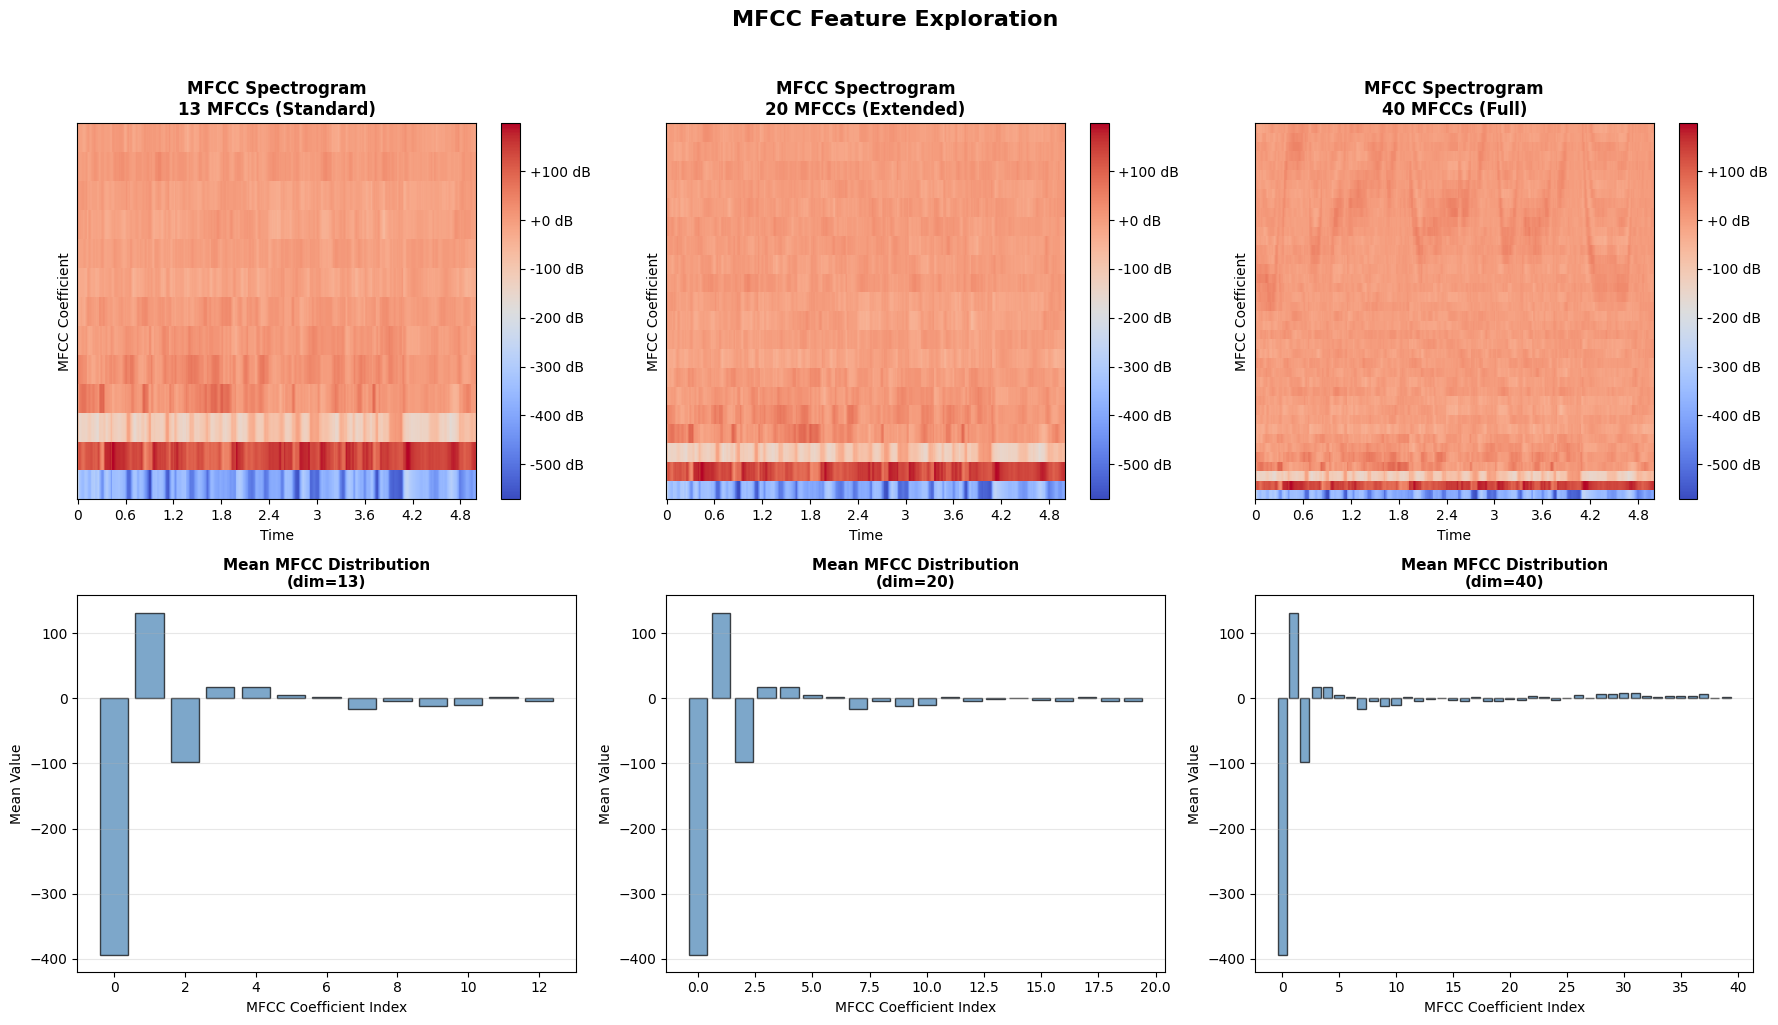


MFCC feature vector (n_mfcc=20):
  Shape: (20, 173)
  Per-frame shape: 20 coefficients
  Min: -493.1010, Max: 223.2612, Mean: -15.6805


In [23]:
# Explore MFCC features with different parameters
mfcc_configs = [
    {'n_mfcc': 13, 'label': '13 MFCCs (Standard)'},
    {'n_mfcc': 20, 'label': '20 MFCCs (Extended)'},
    {'n_mfcc': 40, 'label': '40 MFCCs (Full)'},
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Use a longer segment for visualization
viz_segment = get_audio_segment(full_audio, sr, SAMPLE_AUDIO_SEC, 5)  # 5 seconds

for idx, config in enumerate(mfcc_configs):
    n_mfcc = config['n_mfcc']
    
    # Compute MFCCs
    mfcc = librosa.feature.mfcc(y=viz_segment, sr=sr, n_mfcc=n_mfcc)
    
    # Top row: Spectrogram visualization
    ax_spec = axes[0, idx]
    img = librosa.display.specshow(mfcc, x_axis='time', sr=sr, ax=ax_spec, cmap='coolwarm')
    ax_spec.set_title(f'MFCC Spectrogram\n{config["label"]}', fontsize=12, fontweight='bold')
    ax_spec.set_ylabel('MFCC Coefficient')
    fig.colorbar(img, ax=ax_spec, format='%+2.0f dB')
    
    # Bottom row: Distribution of mean MFCC values
    ax_hist = axes[1, idx]
    mean_mfcc = mfcc.mean(axis=1)
    ax_hist.bar(range(n_mfcc), mean_mfcc, color='steelblue', edgecolor='black', alpha=0.7)
    ax_hist.set_xlabel('MFCC Coefficient Index', fontsize=10)
    ax_hist.set_ylabel('Mean Value', fontsize=10)
    ax_hist.set_title(f'Mean MFCC Distribution\n(dim={n_mfcc})', fontsize=11, fontweight='bold')
    ax_hist.grid(axis='y', alpha=0.3)

plt.suptitle('MFCC Feature Exploration', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print feature info
print(f"\nMFCC feature vector (n_mfcc=20):")
mfcc_default = librosa.feature.mfcc(y=audio_segment, sr=sr, n_mfcc=20)
print(f"  Shape: {mfcc_default.shape}")
print(f"  Per-frame shape: {mfcc_default.shape[0]} coefficients")
print(f"  Min: {mfcc_default.min():.4f}, Max: {mfcc_default.max():.4f}, Mean: {mfcc_default.mean():.4f}")

### Spectral Features (Centroid, Bandwidth, Contrast)

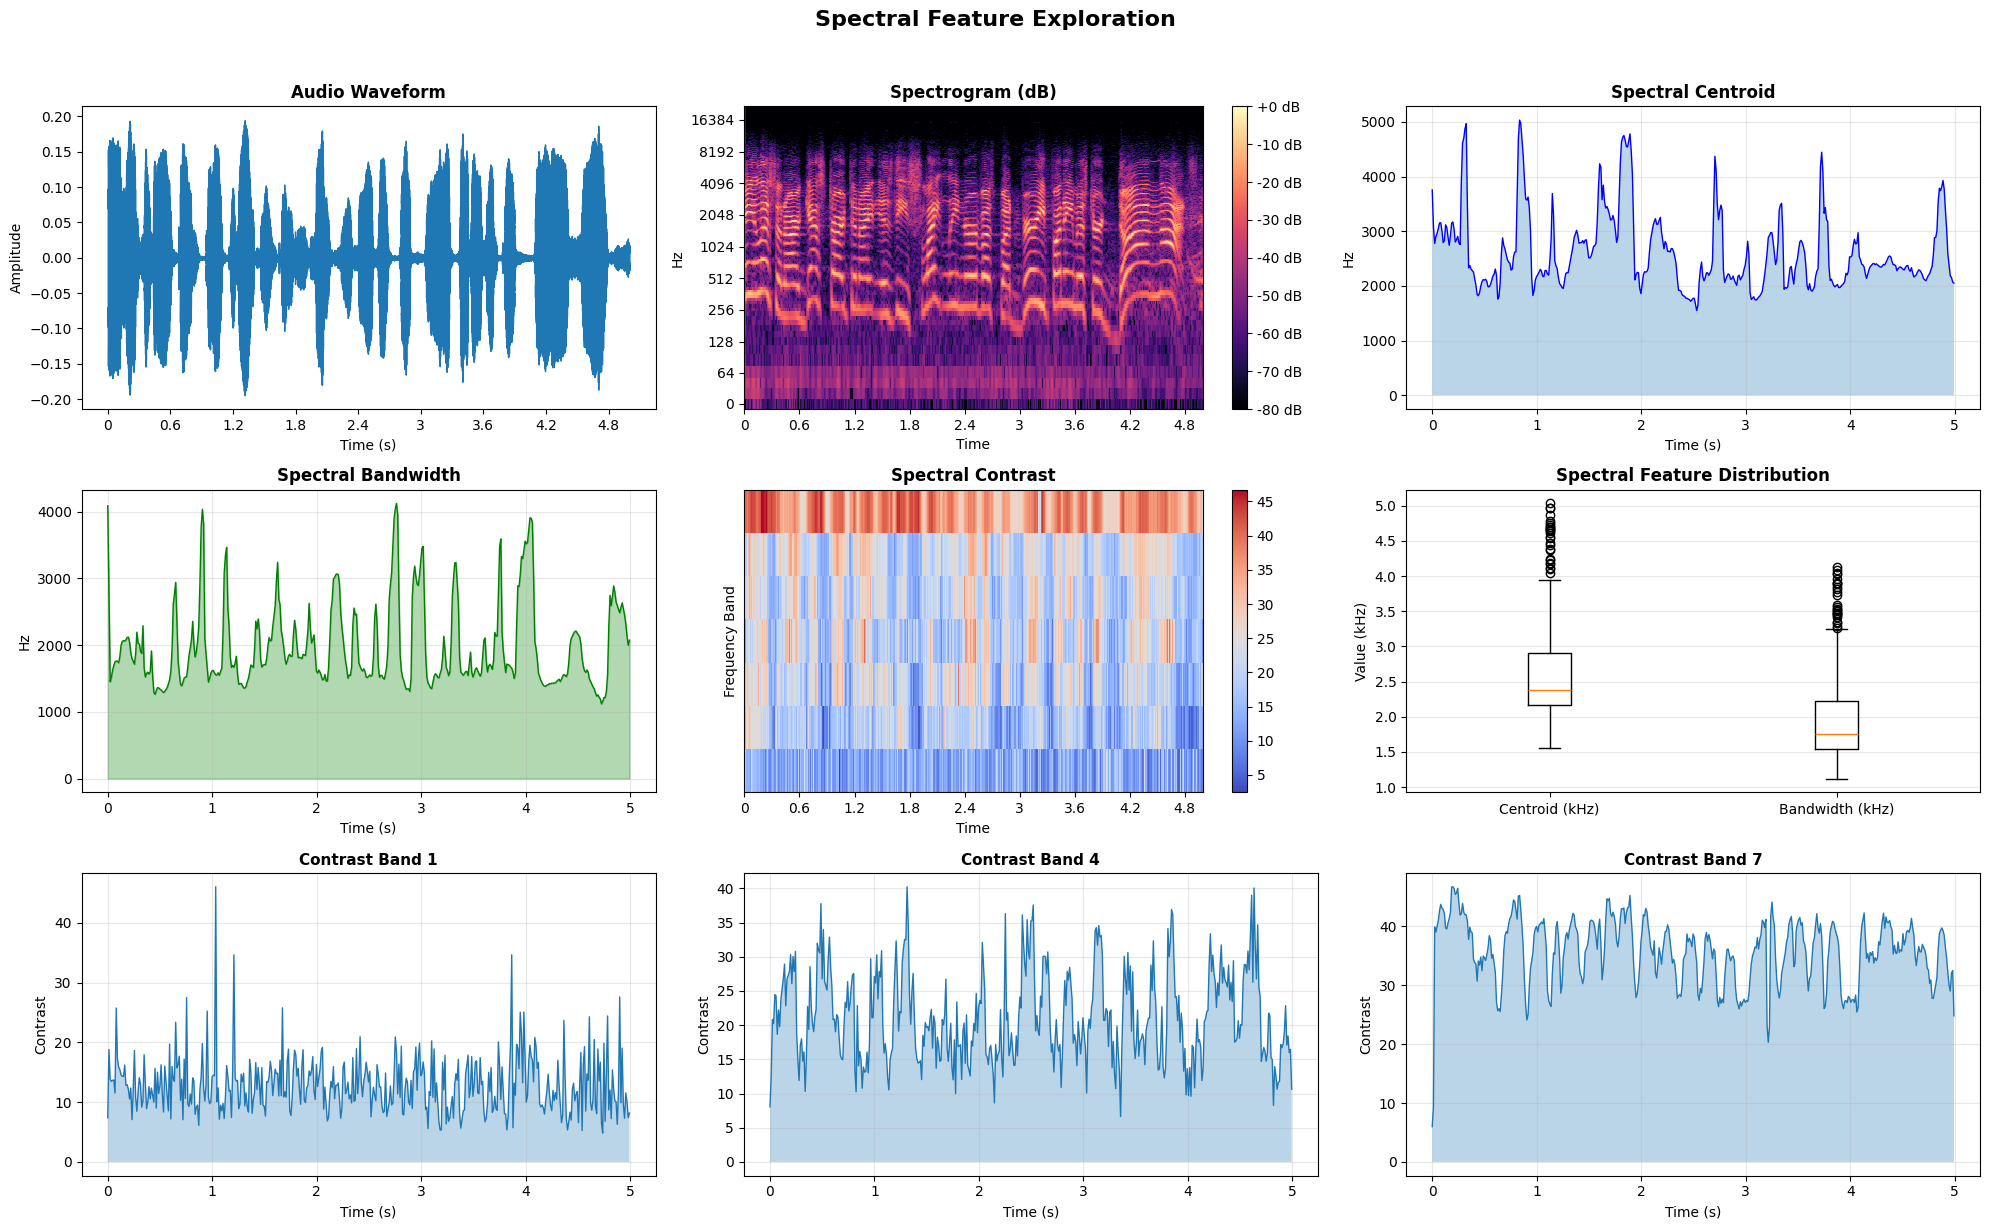


Spectral feature summary:
  Centroid: shape=(431,), mean=2624.05 Hz
  Bandwidth: shape=(431,), mean=1987.79 Hz
  Contrast: shape=(7, 431), 7 frequency bands


In [24]:
fig = plt.figure(figsize=(20, 12))

# Use 5-second segment for visualization
viz_segment = get_audio_segment(full_audio, sr, SAMPLE_AUDIO_SEC, 5)

# 1. Waveform
ax_wave = fig.add_subplot(3, 3, 1)
librosa.display.waveshow(viz_segment, sr=sr, ax=ax_wave)
ax_wave.set_title('Audio Waveform', fontsize=12, fontweight='bold')
ax_wave.set_xlabel('Time (s)')
ax_wave.set_ylabel('Amplitude')

# 2. Spectrogram
ax_spec = fig.add_subplot(3, 3, 2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(viz_segment)), ref=np.max)
img = librosa.display.specshow(D, y_axis='log', x_axis='time', sr=sr, ax=ax_spec)
ax_spec.set_title('Spectrogram (dB)', fontsize=12, fontweight='bold')
fig.colorbar(img, ax=ax_spec, format='%+2.0f dB')

# 3. Spectral Centroid
ax_cent = fig.add_subplot(3, 3, 3)
cent = librosa.feature.spectral_centroid(y=viz_segment, sr=sr)[0]
frames = range(len(cent))
t = librosa.frames_to_time(frames, sr=sr)
ax_cent.plot(t, cent, color='blue', linewidth=1)
ax_cent.fill_between(t, cent, alpha=0.3)
ax_cent.set_title('Spectral Centroid', fontsize=12, fontweight='bold')
ax_cent.set_xlabel('Time (s)')
ax_cent.set_ylabel('Hz')
ax_cent.grid(alpha=0.3)

# 4. Spectral Bandwidth
ax_bw = fig.add_subplot(3, 3, 4)
bw = librosa.feature.spectral_bandwidth(y=viz_segment, sr=sr)[0]
ax_bw.plot(t, bw, color='green', linewidth=1)
ax_bw.fill_between(t, bw, alpha=0.3, color='green')
ax_bw.set_title('Spectral Bandwidth', fontsize=12, fontweight='bold')
ax_bw.set_xlabel('Time (s)')
ax_bw.set_ylabel('Hz')
ax_bw.grid(alpha=0.3)

# 5. Spectral Contrast
ax_con = fig.add_subplot(3, 3, 5)
contrast = librosa.feature.spectral_contrast(y=viz_segment, sr=sr)
img = librosa.display.specshow(contrast, x_axis='time', sr=sr, ax=ax_con, cmap='coolwarm')
ax_con.set_title('Spectral Contrast', fontsize=12, fontweight='bold')
ax_con.set_ylabel('Frequency Band')
fig.colorbar(img, ax=ax_con)

# 6. Distribution comparison
ax_dist = fig.add_subplot(3, 3, 6)
features_data = {
    'Centroid': cent / 1000,  # Scale to kHz for comparison
    'Bandwidth': bw / 1000,
}
ax_dist.boxplot([features_data['Centroid'], features_data['Bandwidth']], 
                labels=['Centroid (kHz)', 'Bandwidth (kHz)'])
ax_dist.set_title('Spectral Feature Distribution', fontsize=12, fontweight='bold')
ax_dist.set_ylabel('Value (kHz)')
ax_dist.grid(axis='y', alpha=0.3)

# 7-9: Individual contrast bands
for i, band_idx in enumerate([0, 3, 6]):
    ax = fig.add_subplot(3, 3, 7 + i)
    ax.plot(t, contrast[band_idx], linewidth=1)
    ax.fill_between(t, contrast[band_idx], alpha=0.3)
    ax.set_title(f'Contrast Band {band_idx + 1}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Contrast')
    ax.grid(alpha=0.3)

plt.suptitle('Spectral Feature Exploration', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print feature info
print(f"\nSpectral feature summary:")
print(f"  Centroid: shape={cent.shape}, mean={cent.mean():.2f} Hz")
print(f"  Bandwidth: shape={bw.shape}, mean={bw.mean():.2f} Hz")
print(f"  Contrast: shape={contrast.shape}, 7 frequency bands")

### Chroma Features

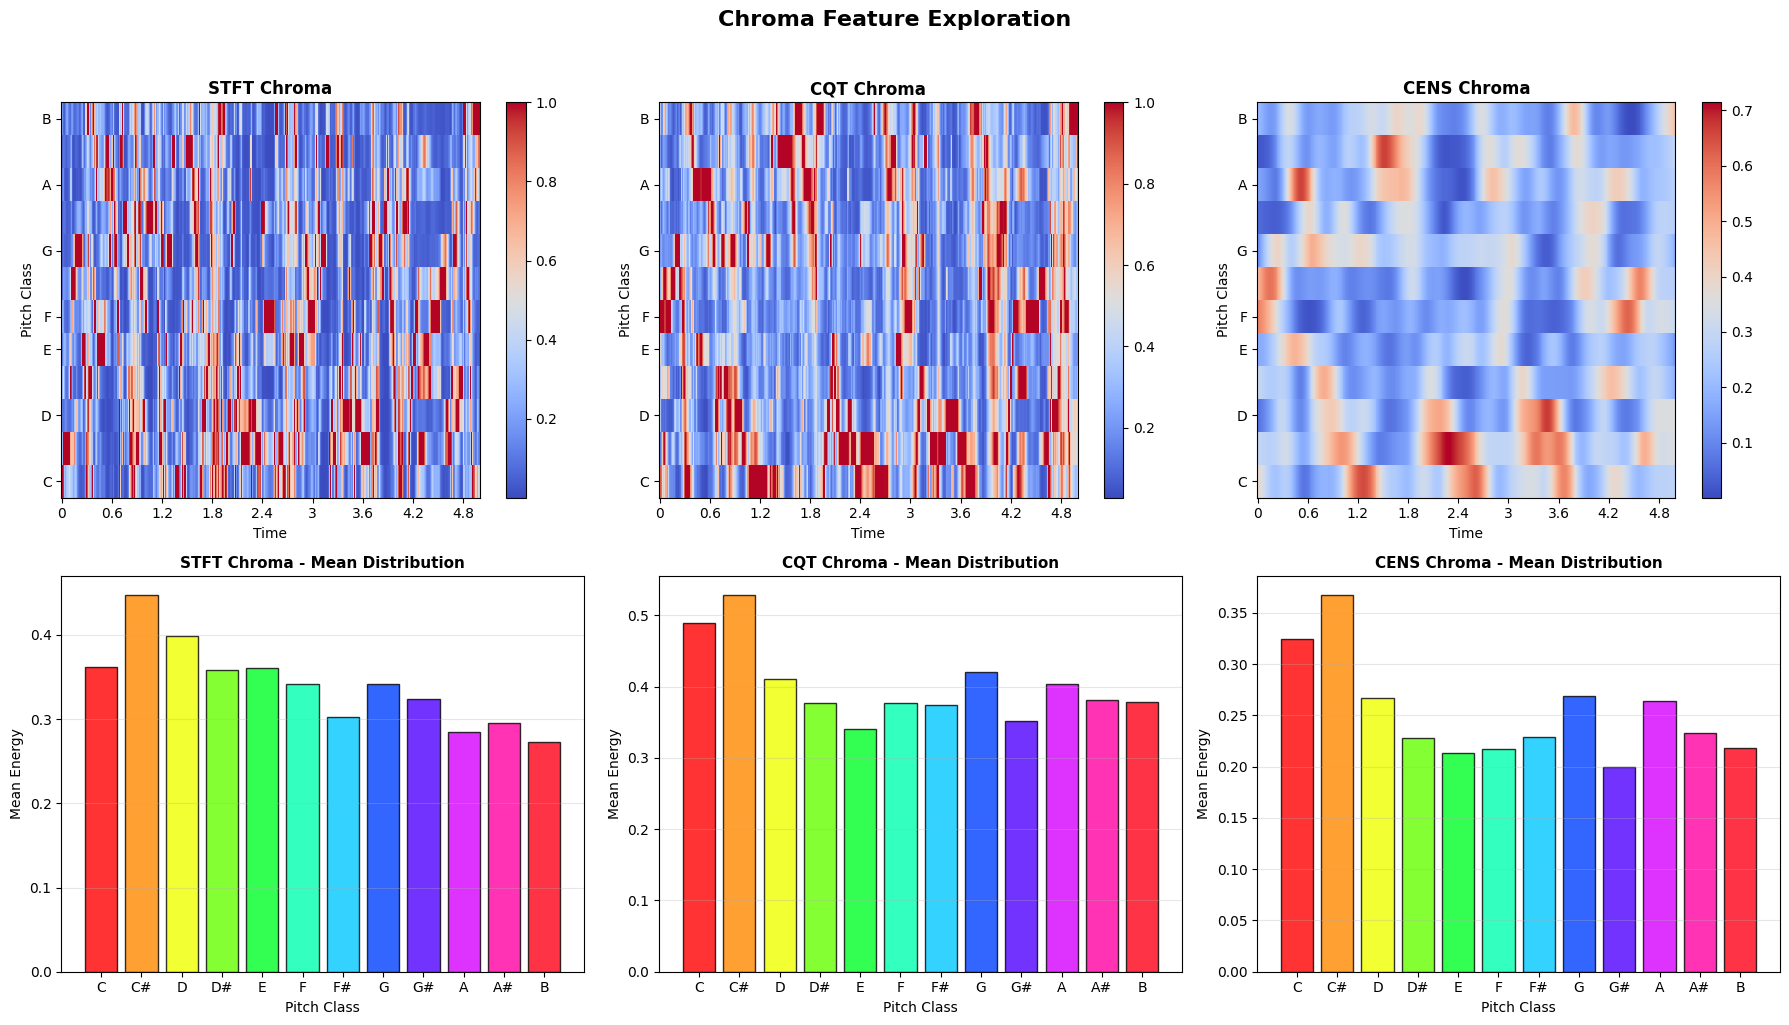


Chroma feature vector:
  Shape: (12, 173)
  12 pitch classes (C, C#, D, ..., B)
  Min: 0.0037, Max: 1.0000, Mean: 0.3436


In [25]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Different chroma extraction methods
chroma_configs = [
    ('STFT Chroma', lambda y, sr: librosa.feature.chroma_stft(y=y, sr=sr)),
    ('CQT Chroma', lambda y, sr: librosa.feature.chroma_cqt(y=y, sr=sr)),
    ('CENS Chroma', lambda y, sr: librosa.feature.chroma_cens(y=y, sr=sr)),
]

viz_segment = get_audio_segment(full_audio, sr, SAMPLE_AUDIO_SEC, 5)
pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

for idx, (name, func) in enumerate(chroma_configs):
    chroma = func(viz_segment, sr)
    
    # Top row: Chromagram visualization
    ax_chroma = axes[0, idx]
    img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr=sr, ax=ax_chroma, cmap='coolwarm')
    ax_chroma.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax_chroma.set_ylabel('Pitch Class')
    fig.colorbar(img, ax=ax_chroma)
    
    # Bottom row: Mean energy per pitch class
    ax_bar = axes[1, idx]
    mean_chroma = chroma.mean(axis=1)
    colors = plt.cm.hsv(np.linspace(0, 1, 12))
    ax_bar.bar(pitch_classes, mean_chroma, color=colors, edgecolor='black', alpha=0.8)
    ax_bar.set_xlabel('Pitch Class', fontsize=10)
    ax_bar.set_ylabel('Mean Energy', fontsize=10)
    ax_bar.set_title(f'{name} - Mean Distribution', fontsize=11, fontweight='bold')
    ax_bar.grid(axis='y', alpha=0.3)

plt.suptitle('Chroma Feature Exploration', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print feature info
print(f"\nChroma feature vector:")
chroma_default = librosa.feature.chroma_stft(y=audio_segment, sr=sr)
print(f"  Shape: {chroma_default.shape}")
print(f"  12 pitch classes (C, C#, D, ..., B)")
print(f"  Min: {chroma_default.min():.4f}, Max: {chroma_default.max():.4f}, Mean: {chroma_default.mean():.4f}")

### Spectral Flux (Onset Strength)

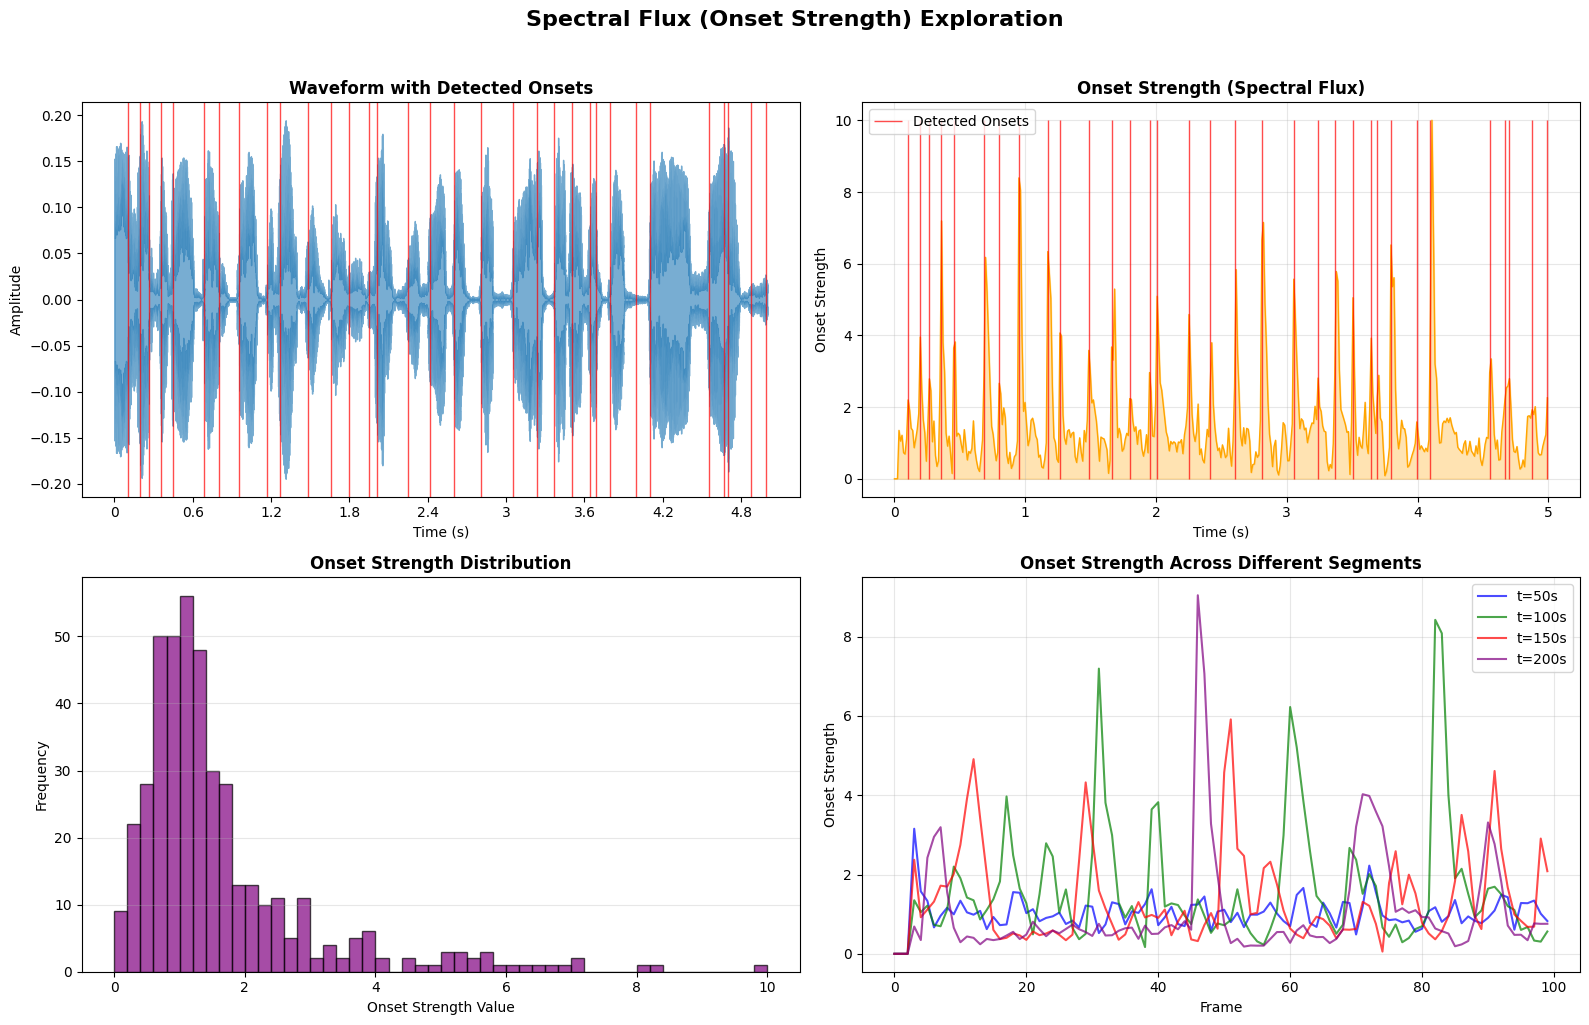


Spectral Flux feature vector:
  Shape: (173,)
  Min: 0.0000, Max: 5.6495, Mean: 1.3230


In [26]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

viz_segment = get_audio_segment(full_audio, sr, SAMPLE_AUDIO_SEC, 5)

# 1. Waveform with onset detection
ax_wave = axes[0, 0]
librosa.display.waveshow(viz_segment, sr=sr, ax=ax_wave, alpha=0.6)
onset_frames = librosa.onset.onset_detect(y=viz_segment, sr=sr)
onset_times = librosa.frames_to_time(onset_frames, sr=sr)
for onset in onset_times:
    ax_wave.axvline(x=onset, color='red', alpha=0.7, linewidth=1)
ax_wave.set_title('Waveform with Detected Onsets', fontsize=12, fontweight='bold')
ax_wave.set_xlabel('Time (s)')
ax_wave.set_ylabel('Amplitude')

# 2. Onset strength envelope
ax_onset = axes[0, 1]
onset_env = librosa.onset.onset_strength(y=viz_segment, sr=sr)
times = librosa.times_like(onset_env, sr=sr)
ax_onset.plot(times, onset_env, color='orange', linewidth=1)
ax_onset.fill_between(times, onset_env, alpha=0.3, color='orange')
ax_onset.vlines(onset_times, 0, onset_env.max(), color='red', alpha=0.7, linewidth=1, label='Detected Onsets')
ax_onset.set_title('Onset Strength (Spectral Flux)', fontsize=12, fontweight='bold')
ax_onset.set_xlabel('Time (s)')
ax_onset.set_ylabel('Onset Strength')
ax_onset.legend()
ax_onset.grid(alpha=0.3)

# 3. Histogram of onset strength values
ax_hist = axes[1, 0]
ax_hist.hist(onset_env, bins=50, color='purple', edgecolor='black', alpha=0.7)
ax_hist.set_title('Onset Strength Distribution', fontsize=12, fontweight='bold')
ax_hist.set_xlabel('Onset Strength Value')
ax_hist.set_ylabel('Frequency')
ax_hist.grid(axis='y', alpha=0.3)

# 4. Comparison across different segments
ax_comp = axes[1, 1]
segment_starts = [50, 100, 150, 200]  # Different time points
colors = ['blue', 'green', 'red', 'purple']
for start, color in zip(segment_starts, colors):
    seg = get_audio_segment(full_audio, sr, start, 3)
    if len(seg) > 0:
        env = librosa.onset.onset_strength(y=seg, sr=sr)
        ax_comp.plot(env[:100], color=color, alpha=0.7, label=f't={start}s')
ax_comp.set_title('Onset Strength Across Different Segments', fontsize=12, fontweight='bold')
ax_comp.set_xlabel('Frame')
ax_comp.set_ylabel('Onset Strength')
ax_comp.legend()
ax_comp.grid(alpha=0.3)

plt.suptitle('Spectral Flux (Onset Strength) Exploration', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print feature info
print(f"\nSpectral Flux feature vector:")
flux_default = librosa.onset.onset_strength(y=audio_segment, sr=sr)
print(f"  Shape: {flux_default.shape}")
print(f"  Min: {flux_default.min():.4f}, Max: {flux_default.max():.4f}, Mean: {flux_default.mean():.4f}")

### All Audio Features Summary

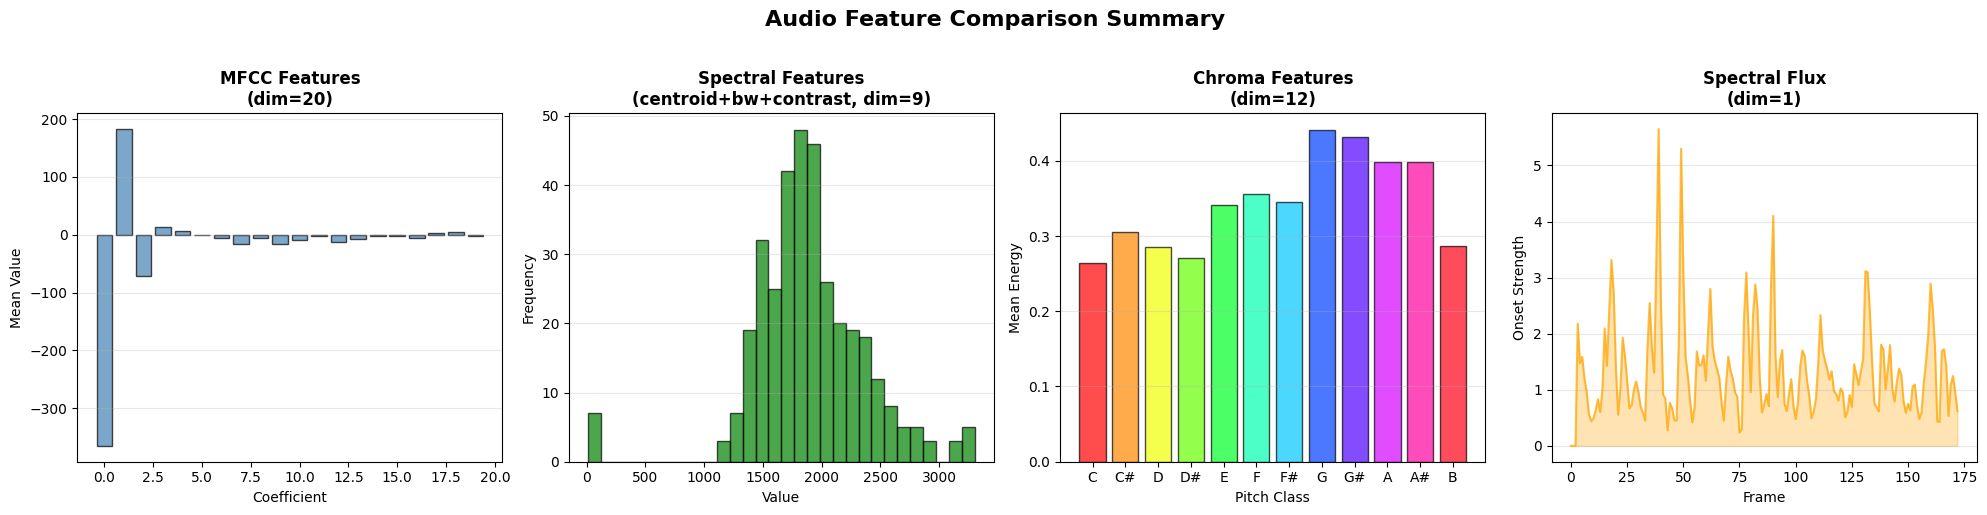


AUDIO FEATURE DIMENSIONALITY SUMMARY
MFCC:         20 dimensions
Spectral:      9 dimensions (1 centroid + 1 bandwidth + 7 contrast)
Chroma:       12 dimensions (12 pitch classes)
Flux:          1 dimension
------------------------------------------------------------
TOTAL:        42 dimensions per frame


In [27]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Extract features from sample segment
hop_length = int(sr / SAMPLE_FPS)

mfcc_feat = librosa.feature.mfcc(y=audio_segment, sr=sr, n_mfcc=20)
spec_cent = librosa.feature.spectral_centroid(y=audio_segment, sr=sr)
spec_bw = librosa.feature.spectral_bandwidth(y=audio_segment, sr=sr)
spec_con = librosa.feature.spectral_contrast(y=audio_segment, sr=sr)
chroma_feat = librosa.feature.chroma_stft(y=audio_segment, sr=sr)
flux_feat = librosa.onset.onset_strength(y=audio_segment, sr=sr)

# 1. MFCC
axes[0].bar(range(20), mfcc_feat.mean(axis=1), alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_title(f'MFCC Features\n(dim=20)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Coefficient')
axes[0].set_ylabel('Mean Value')
axes[0].grid(axis='y', alpha=0.3)

# 2. Spectral (combined)
spec_combined = np.concatenate([
    spec_cent.flatten(),
    spec_bw.flatten(),
    spec_con.mean(axis=1)
])
axes[1].hist(spec_combined, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1].set_title(f'Spectral Features\n(centroid+bw+contrast, dim=9)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y', alpha=0.3)

# 3. Chroma
pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
colors = plt.cm.hsv(np.linspace(0, 1, 12))
axes[2].bar(pitch_classes, chroma_feat.mean(axis=1), alpha=0.7, color=colors, edgecolor='black')
axes[2].set_title(f'Chroma Features\n(dim=12)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Pitch Class')
axes[2].set_ylabel('Mean Energy')
axes[2].grid(axis='y', alpha=0.3)

# 4. Flux
axes[3].plot(flux_feat, alpha=0.7, color='orange')
axes[3].fill_between(range(len(flux_feat)), flux_feat, alpha=0.3, color='orange')
axes[3].set_title(f'Spectral Flux\n(dim=1)', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Frame')
axes[3].set_ylabel('Onset Strength')
axes[3].grid(axis='y', alpha=0.3)

plt.suptitle('Audio Feature Comparison Summary', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("AUDIO FEATURE DIMENSIONALITY SUMMARY")
print("="*60)
print(f"MFCC:     {20:>6} dimensions")
print(f"Spectral: {9:>6} dimensions (1 centroid + 1 bandwidth + 7 contrast)")
print(f"Chroma:   {12:>6} dimensions (12 pitch classes)")
print(f"Flux:     {1:>6} dimension")
print("-"*60)
print(f"TOTAL:    {42:>6} dimensions per frame")
print("="*60)

## Building Datasets

In [28]:
def get_label(video_id, frame_idx, gt_df):
    try:
        row = gt_df.loc[(video_id, frame_idx)]
    except KeyError:
        return None

    # 1. Miss Piggy takes the frame.
    if row["MissPiggy"] == 1:
        return "MissPiggy"

    # 2. 'OtherPigs' is ONLY valid if Miss Piggy is NOT present.
    if row["OtherPigs"] == 1 and row["MissPiggy"] == 0:
        return "OtherPigs"

    # 3. Rest of the classes
    if row["SwedishChef"] == 1:
        return "SwedishChef"
    if row["Rowlf"] == 1:
        return "Rowlf"

    return None


def video_iter_frames(path):
    """go through video frame by frame and yield (idx, frame_bgr, fps, nframes)"""
    capture = cv2.VideoCapture(path)
    if not capture.isOpened():
        raise RuntimeError(f"cannot open video: {path}")

    fps = capture.get(cv2.CAP_PROP_FPS)
    total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_index = 0
    try:
        while True:
            ok, frame = capture.read()
            if not ok:
                break
            yield frame_index, frame, fps, total_frames
            frame_index += 1
    finally:
        capture.release()

In [30]:
if os.path.exists(CACHE_FILE):
    print(f"Cache found at {CACHE_FILE}. Loading finished datasets...")
    with np.load(CACHE_FILE) as data:
        X_mfcc_frames = data['X_mfcc_frames']
        X_spec_frames = data['X_spec_frames']
        X_chroma_frames = data['X_chroma_frames']
        X_flux_frames = data['X_flux_frames']
        y_labels = data['y_labels']
        video_ids_per_frame = data['video_ids_per_frame']
    
    print("Datasets loaded successfully.")
else:
    print("No cache found.")

No cache found.


In [31]:
if not os.path.exists(CACHE_FILE):
    # audio features
    mfcc_frames = []
    spec_frames = []
    chroma_frames = []
    flux_frames = []

    frame_meta = []  # list of (video_id, frame_idx)
    labels_per_frame = []

    for video_path in VIDEO_FILES:
        video_id = int(os.path.splitext(os.path.basename(video_path))[0])
        print("processing video:", video_id)

        # get fps and total frames
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()

        # load per-frame audio features
        audio_path = os.path.join(AUDIO_DIR, f"{video_id}.wav")
        audio_feats = extract_audio_features_vectorized(
            audio_path,
            fps,
            total_frames,
            n_mfcc=20
        )

        # loop over frames and grab features for labeled frames only
        for frame_idx, frame_bgr, fps, total_frames in video_iter_frames(video_path):
            # get label
            label = get_label(video_id, frame_idx, gt_df)
            if label is None:
                continue

            # meta + label
            frame_meta.append((video_id, frame_idx))
            labels_per_frame.append(label)

            # audio features: just index by frame_idx
            mfcc_frames.append(audio_feats["mfcc"][frame_idx])
            spec_frames.append(audio_feats["spec"][frame_idx])
            chroma_frames.append(audio_feats["chroma"][frame_idx])
            flux_frames.append(audio_feats["flux"][frame_idx])

    # convert to arrays
    X_mfcc_frames = np.vstack(mfcc_frames)
    X_spec_frames = np.vstack(spec_frames)
    X_chroma_frames = np.vstack(chroma_frames)
    X_flux_frames = np.vstack(flux_frames)

    y_labels = np.array(labels_per_frame)
    meta_array = np.array(frame_meta)
    video_ids_per_frame = meta_array[:, 0]

processing video: 211
processing video: 343
processing video: 244


In [32]:
if not os.path.exists(CACHE_FILE):
    print("\n================ audio feature matrices =================")
    print("X_mfcc_frames  :", X_mfcc_frames.shape)
    print("X_spec_frames  :", X_spec_frames.shape)
    print("X_chroma_frames:", X_chroma_frames.shape)
    print("X_flux_frames  :", X_flux_frames.shape)
    print("\nnumber of labels:", len(y_labels))

    # Save to cache
    print(f"\nSaving datasets to {CACHE_FILE}...")
    np.savez_compressed(
        CACHE_FILE,
        X_mfcc_frames=X_mfcc_frames,
        X_spec_frames=X_spec_frames,
        X_chroma_frames=X_chroma_frames,
        X_flux_frames=X_flux_frames,
        y_labels=y_labels,
        video_ids_per_frame=video_ids_per_frame
    )
    print("Cache saved successfully.")


================ audio feature matrices =================
X_mfcc_frames  : (29394, 20)
X_spec_frames  : (29394, 9)
X_chroma_frames: (29394, 12)
X_flux_frames  : (29394, 1)

number of labels: 29394

Saving datasets to ./data/audio_features.npz...
Cache saved successfully.


## Comparing Features

In [33]:
def evaluate_feature(X, y, name):
    # split once, same split for all features
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

    # scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # svm classifier
    clf = SVC(kernel="rbf", C=10, gamma="scale")
    clf.fit(X_train, y_train)

    pred = clf.predict(X_test)
    f1 = f1_score(y_test, pred, average="macro")

    return f1

In [34]:
audio_features = [
    (X_mfcc_frames, "MFCC"),
    (X_spec_frames, "Spectral"),
    (X_chroma_frames, "Chroma"),
    (X_flux_frames, "Flux"),
]

audio_scores = []
for X, name in audio_features:
    f1 = evaluate_feature(X, y_labels, name)
    audio_scores.append((name, f1))

audio_ranked = sorted(audio_scores, key=lambda x: x[1], reverse=True)

print("\n===== audio feature ranking =====")
for name, f1 in audio_ranked:
    print(f"{name:12s}  f1 = {f1:.4f}")


===== audio feature ranking =====
MFCC          f1 = 0.7603
Spectral      f1 = 0.4693
Chroma        f1 = 0.3508
Flux          f1 = 0.1654


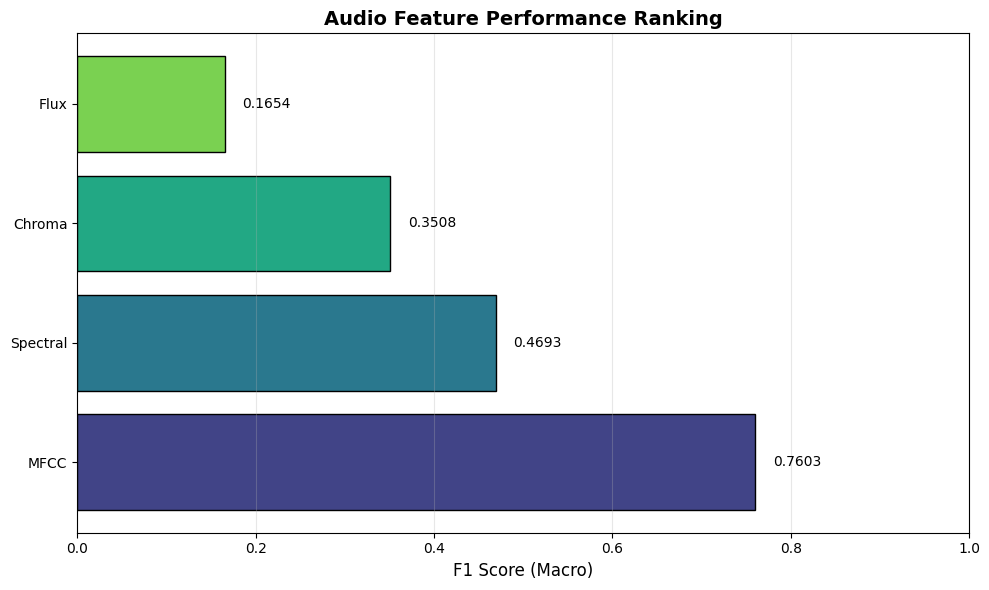

In [35]:
# Visualize feature ranking
fig, ax = plt.subplots(figsize=(10, 6))
names = [x[0] for x in audio_ranked]
scores = [x[1] for x in audio_ranked]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(names)))

bars = ax.barh(names, scores, color=colors, edgecolor='black')
ax.set_xlabel('F1 Score (Macro)', fontsize=12)
ax.set_title('Audio Feature Performance Ranking', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1)

# Add value labels
for bar, score in zip(bars, scores):
    ax.text(score + 0.02, bar.get_y() + bar.get_height()/2, f'{score:.4f}', 
            va='center', fontsize=10)

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### PCA Visualization

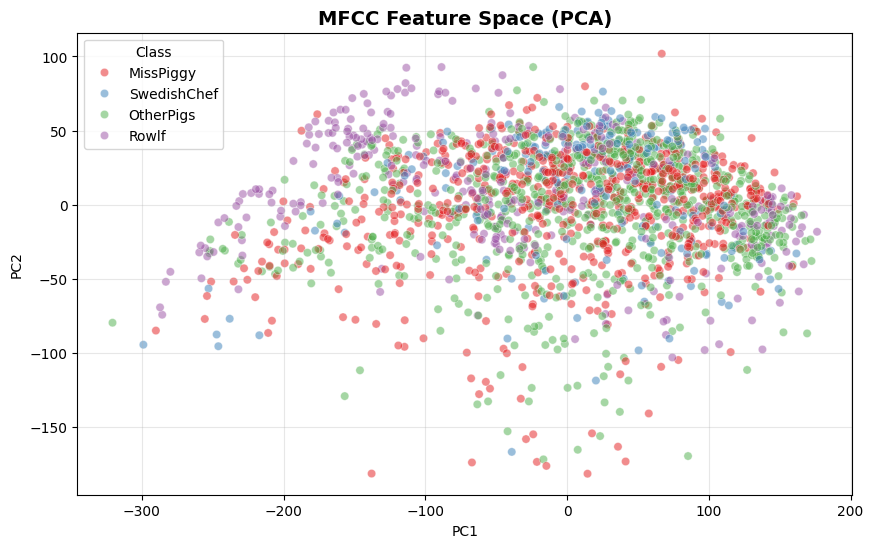

In [36]:
def plot_pca_separation(X, y, title="PCA Feature Space"):
    # Reduce to 2 dimensions for plotting
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Create a DataFrame for easy plotting with Seaborn
    df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    df_pca['Label'] = y
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Label', alpha=0.5, palette='Set1')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(title='Class')
    plt.grid(alpha=0.3)
    plt.show()

# Use a subset to speed up plotting
subset_idx = np.random.choice(len(y_labels), min(2000, len(y_labels)), replace=False)
plot_pca_separation(X_mfcc_frames[subset_idx], y_labels[subset_idx], "MFCC Feature Space (PCA)")

## Classification

In [37]:
def get_train_test_indices(groups, test_size=0.2, random_state=SEED):
    """Splits data so that all frames from one video are EITHER in train OR test."""
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(gss.split(X=groups, y=groups, groups=groups))
    return train_idx, test_idx


def scale_train_test(X_train, X_test):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    return X_train_s, X_test_s

In [38]:
# fit once on all labels
label_encoder = LabelEncoder()
y_all_enc = label_encoder.fit_transform(y_labels)

# indices used to split so all models share the same train/test frames
idx_train, idx_test = get_train_test_indices(video_ids_per_frame)

y_train_enc = y_all_enc[idx_train]
y_test_enc = y_all_enc[idx_test]

# Build combined audio dataset (excluding flux due to low performance)
ds_audio = np.hstack((X_mfcc_frames, X_spec_frames, X_chroma_frames))

ds_audio_train = ds_audio[idx_train]
ds_audio_test = ds_audio[idx_test]

ds_audio_train_s, ds_audio_test_s = scale_train_test(ds_audio_train, ds_audio_test)

print(f"Training samples: {len(idx_train)}")
print(f"Test samples: {len(idx_test)}")
print(f"Audio feature dimension: {ds_audio.shape[1]}")

Training samples: 22788
Test samples: 6606
Audio feature dimension: 41


### MLP

In [39]:
cls_mlp = MLPClassifier(
    hidden_layer_sizes=(64,),
    max_iter=200,
    early_stopping=True,
    random_state=SEED
)

cls_mlp.fit(ds_audio_train_s, y_train_enc)
pred_audio_mlp = cls_mlp.predict(ds_audio_test_s)
f1_audio_mlp = f1_score(y_test_enc, pred_audio_mlp, average="macro")
print(f"[AUDIO] + [MLP] -> F1-Score: {f1_audio_mlp:.4f}")

[AUDIO] + [MLP] -> F1-Score: 0.1761


### SVM

In [40]:
cls_svm = SVC(kernel="rbf", C=10.0, gamma="scale", random_state=SEED)

cls_svm.fit(ds_audio_train_s, y_train_enc)
pred_audio_svm = cls_svm.predict(ds_audio_test_s)
print(f"[AUDIO] + [SVM] -> F1-Score: {f1_score(y_test_enc, pred_audio_svm, average='macro'):.4f}")

[AUDIO] + [SVM] -> F1-Score: 0.1919


### Random Forest

In [41]:
cls_rf = RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)

cls_rf.fit(ds_audio_train_s, y_train_enc)
pred_audio_rf = cls_rf.predict(ds_audio_test_s)
print(f"[AUDIO] + [RF] -> F1-Score: {f1_score(y_test_enc, pred_audio_rf, average='macro'):.4f}")

[AUDIO] + [RF] -> F1-Score: 0.1450


## Evaluation

In [42]:
def plot_multiclass_roc(models_dict, X_test, y_test, classes):
    """
    Plot ROC curves for multiple models and multiple classes.
    """
    n_classes = len(classes)
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    
    fig, axes = plt.subplots(1, n_classes, figsize=(5 * n_classes, 5))
    if n_classes == 1: 
        axes = [axes]
    
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    
    for i, class_name in enumerate(classes):
        ax = axes[i]
        
        for model_idx, (model_name, model) in enumerate(models_dict.items()):
            color = colors[model_idx % len(colors)]
            
            try:
                if hasattr(model, "decision_function"):
                    y_score = model.decision_function(X_test)
                else:
                    y_score = model.predict_proba(X_test)
                
                if y_score.ndim > 1:
                    y_score_class = y_score[:, i]
                else:
                    y_score_class = y_score
            except AttributeError:
                print(f"Warning: {model_name} failed to produce scores.")
                continue
            
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_class)
            roc_auc = auc(fpr, tpr)
            
            ax.plot(fpr, tpr, lw=2, color=color,
                    label=f'{model_name} (AUC = {roc_auc:.2f})')
        
        ax.plot([0, 1], [0, 1], 'k--', lw=1)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC: {class_name}')
        ax.legend(loc="lower right")
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

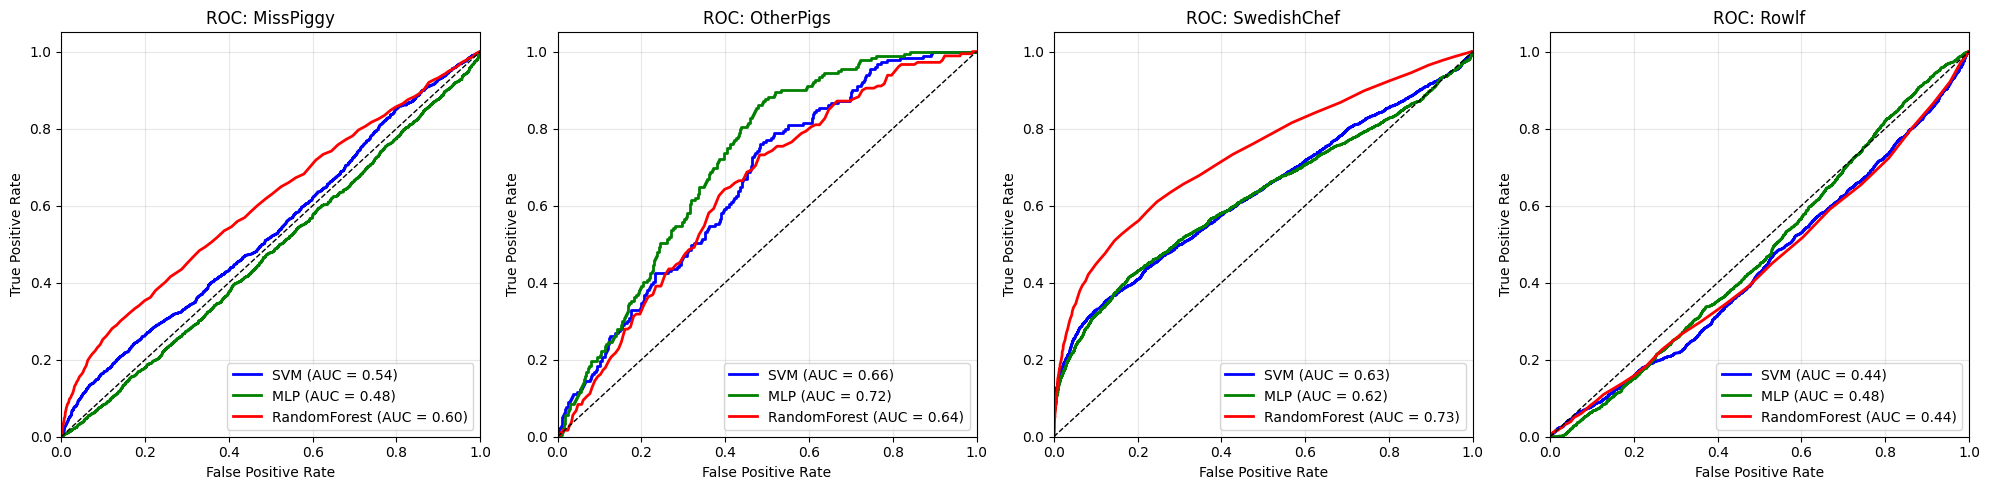

In [43]:
models = {'SVM': cls_svm, 'MLP': cls_mlp, 'RandomForest': cls_rf}
plot_multiclass_roc(models, ds_audio_test_s, y_test_enc, CLASSES)

In [44]:
def evaluate_detailed(model, X_test, y_test, class_names, model_name="Model"):
    y_pred = model.predict(X_test)
    
    print(f"\n--- Detailed Report for {model_name} ---")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()


--- Detailed Report for SVM (Audio) ---
              precision    recall  f1-score   support

   MissPiggy       0.26      0.37      0.31      1661
   OtherPigs       0.04      0.77      0.08       179
 SwedishChef       0.83      0.22      0.34      3036
       Rowlf       0.27      0.02      0.04      1730

    accuracy                           0.22      6606
   macro avg       0.35      0.34      0.19      6606
weighted avg       0.52      0.22      0.25      6606



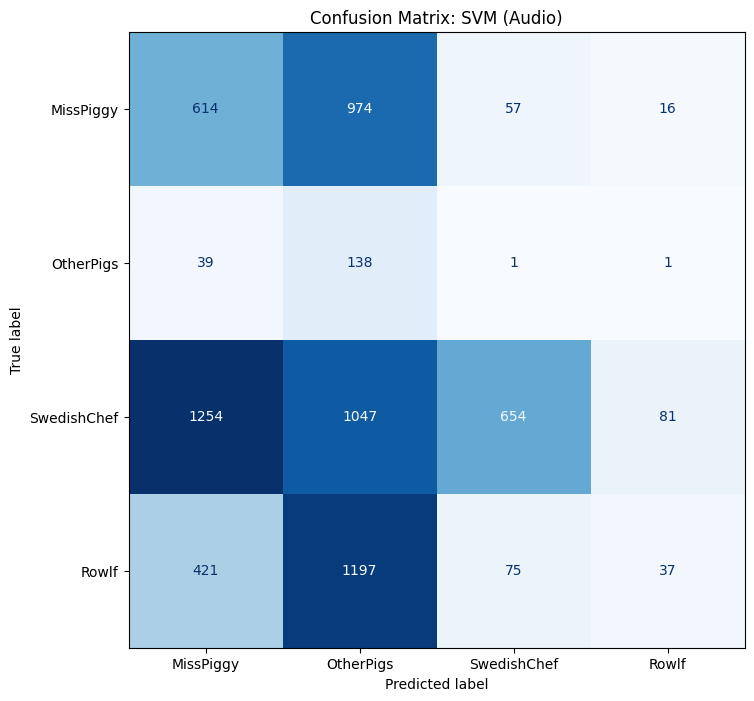

In [45]:
# Evaluate best performing model
evaluate_detailed(cls_svm, ds_audio_test_s, y_test_enc, CLASSES, "SVM (Audio)")